In [1]:
## required inputs
load('windProductionScenarios.rda')
load('initialCurves.rda')
load('loadForecast.rda')
PTFbenchmark=read.csv('PTF-08122017-14122017.csv',sep = ';', dec = ',')
load('offPeakIndex.rda')
load('peakIndex.rda')

daysToForecast=seq.Date(as.Date('2017-12-15'), as.Date('2018-02-28'), by='days')
initialWind=read.csv('GercekZamanliUretim-08122017-14122017.csv', sep = ';', dec = ',')
coeffs<-read.csv('goldens.csv',sep = ';', dec = ',')[,2]

In [18]:
# forecasted day (1 = 15th December)
i=1

# wind scenario among 400 different alternatives
j=1

benchmarkDay=daysToForecast[i]-1
    
if(i==1) {
  benchmarkWind=data.frame(date=benchmarkDay,hour=0:23,value=initialWind[as.Date(initialWind$Tarih,format='%d.%m.%Y')==benchmarkDay,3])
  supplyDemandCurves=curveInput[curveInput$date==benchmarkDay,]
  benchmarkPTF=data.frame(hour=seq(from=as.POSIXct(paste(benchmarkDay,'00:00',sep = ' '),tz='UTC'),length.out = 24,by='hours'),marketTradePrice=PTFbenchmark[as.Date(PTFbenchmark$Tarih, format='%d/%m/%Y')==benchmarkDay,3])
}

benchmarkLoad=data.frame(date=benchmarkDay,hour=0:23,load=hourlyForecast[as.Date(substr(hourlyForecast$hour,1,10))==benchmarkDay,2])
dayAheadLoad=data.frame(date=daysToForecast[i],hour=0:23,load=hourlyForecast[as.Date(substr(hourlyForecast$hour,1,10))==daysToForecast[i],2])

forecastResult<-rbind(benchmarkLoad,dayAheadLoad)
colnames(forecastResult)<-c("tarih","saat","value")


dayAheadWind=data.frame(date=daysToForecast[i],hour=0:23,value=windProductionScenarios[as.Date(substr(rownames(windProductionScenarios),1,10))==daysToForecast[i],j])

windForecast=rbind(benchmarkWind,dayAheadWind)

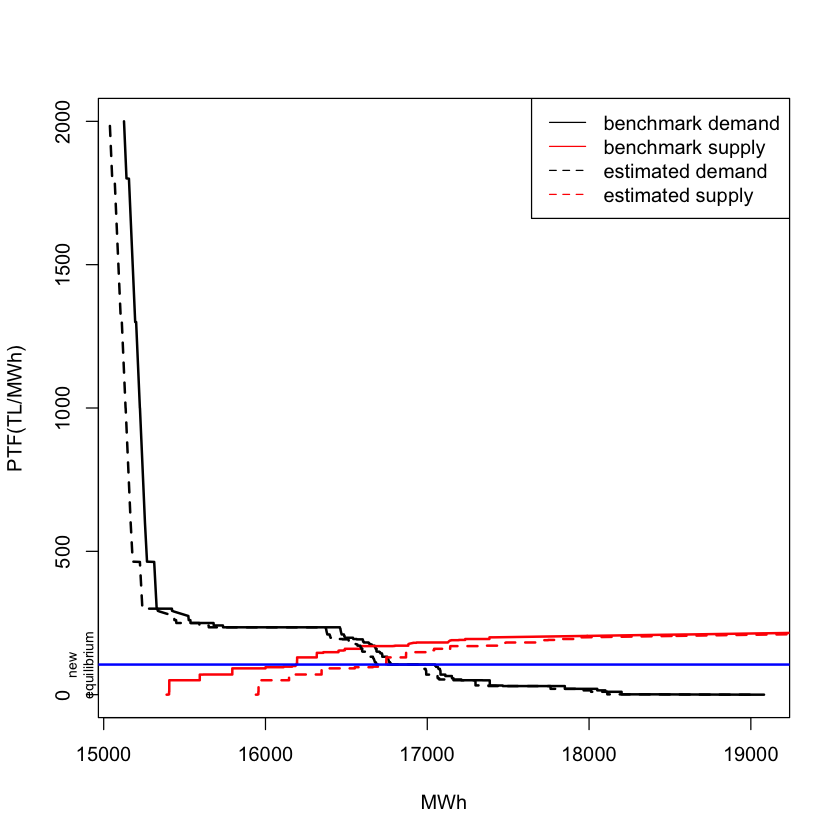

In [28]:
## shifting curves with delta demand and delta supply to estimate new equilibrium
shifts<-data.frame(hour=0:23,supply=windForecast$value[25:48]-windForecast$value[1:24],demand=(forecastResult$value[25:48]-forecastResult$value[1:24]))
newCurves<-data.frame(date=daysToForecast[i],hour=supplyDemandCurves[,2], price=supplyDemandCurves$price)
# *coeffs[newCurves$hour[x]+1]
newCurves$supply=sapply(1:nrow(newCurves), function(x) abs(supplyDemandCurves$supply[x])+shifts[shifts$hour==newCurves$hour[x],2])
newCurves$demand=sapply(1:nrow(newCurves), function(x) abs(supplyDemandCurves$demand[x])+shifts[shifts$hour==newCurves$hour[x],3]*coeffs[newCurves$hour[x]+1])
newCurves$margin=abs(newCurves$supply-newCurves$demand)
localMinIndex=sapply(1:nrow(newCurves), function(i) if(i==1 | i==nrow(newCurves)) {0} else {if(newCurves$margin[i-1]>newCurves$margin[i] & newCurves$margin[i+1]>newCurves$margin[i]) {1} else {0}})
eqCheck<-aggregate(localMinIndex,by=list(newCurves$hour),sum)
#if(length(which(localMinIndex==1))!=24) {localMinIndex[which(newCurves$hour==eqCheck[which(eqCheck[,2]==0),1] & newCurves$price==0)]<-1} else {}
predicted=newCurves[localMinIndex==1,]
peakHourCurve=supplyDemandCurves[supplyDemandCurves$hour==16,]
newPeakHourCurve=newCurves[newCurves$hour==16,]
plot(peakHourCurve$demand,peakHourCurve$price, type='l', xlab='MWh',ylab='PTF(TL/MWh)',lty=1,lwd = 2)
lines(abs(peakHourCurve$supply),peakHourCurve$price, col='red',lty=1,lwd = 2)
lines(newPeakHourCurve$demand,newPeakHourCurve$price,col='black', lty=2, lwd=2)
lines(abs(newPeakHourCurve$supply),newPeakHourCurve$price, col='red',lty=2,lwd = 2)
legend('topright',legend = c('benchmark demand', 'benchmark supply', 'estimated demand','estimated supply'), col = c('black','red','black','red'), lty = c(1,1,2,2),cex = 1)
peakHourIndex=localMinIndex[newCurves$hour==16]
abline(h=newPeakHourCurve[peakHourIndex==1,3], col='blue',lwd=2)
mtext('new\nequilibrium',2,at=newPeakHourCurve[peakHourIndex==1,3],col = 'black', cex = .7)

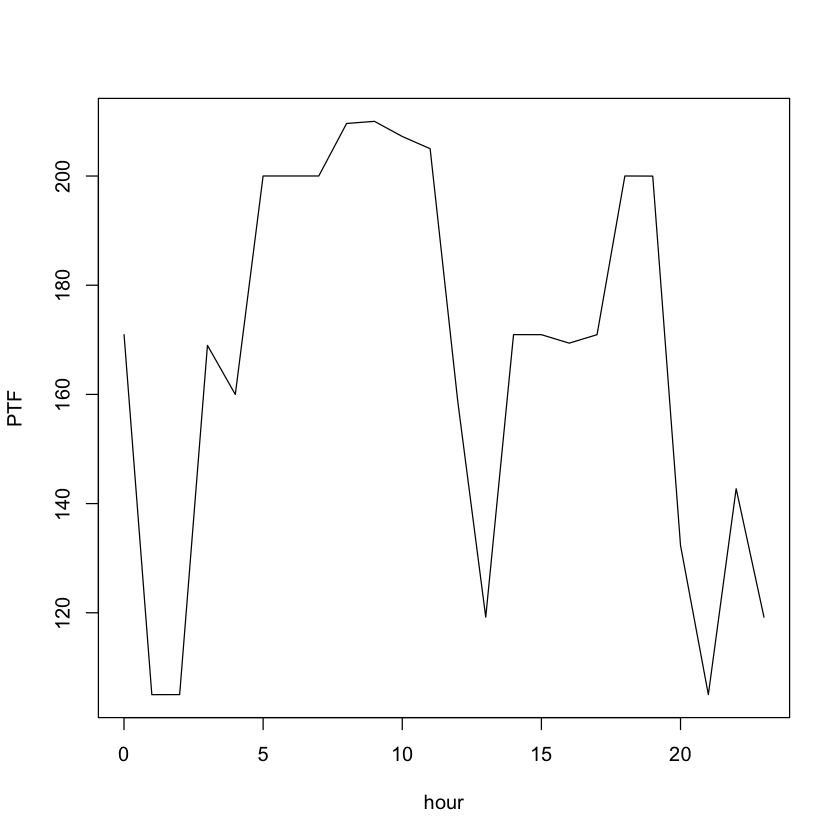

In [30]:
benchmarkPTF$sim=predicted$price

benchmarkPTF$peak<-rep(0,nrow(benchmarkPTF))
benchmarkPTF$peak[which(as.integer(substr(benchmarkPTF$hour,12,13)) %in% 8:19)]<-1
#offPeakIndex<-read.xlsx('blockMoves.xlsx',sheetName = 'OFFPEAK')
#peakIndex<-read.xlsx('blockMoves.xlsx',sheetName = 'PEAK')

sim1<-aggregate(benchmarkPTF[,2:3], by=list(benchmarkPTF$peak), mean)
colnames(sim1)[1]<-"peak"
sim1$blockLevel<-sapply(1:nrow(sim1), function(i) if(sim1[i,1]==0) {which(abs(offPeakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)==min(abs(offPeakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)))[1]} else {which(abs(peakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)==min(abs(peakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)))[1]})
# sim1$blockChange<-sapply(1:nrow(sim1), function(i) if(sim1[i,1]==0) {offPeakIndex$addedBlock[which(abs(offPeakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)==min(abs(offPeakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)))]} else {peakIndex$addedBlock[which(abs(peakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)==min(abs(peakIndex$price-floor(sim1$marketTradePrice[i]/5)*5)))]})
sim1$desicion<-(sim1$sim-sim1$marketTradePrice)/abs(sim1$sim-sim1$marketTradePrice)

fncBlockMove<-function(peakMove,offPeakMove) {
  addedBlock<-sapply(1:nrow(benchmarkPTF), function(x) if(benchmarkPTF$peak[x]==0) {sum(offPeakIndex[(sim1$blockLevel[1]+sim1$desicion[1]*round(offPeakMove)):sim1$blockLevel[1],2][-1])*sim1$desicion[1]} else {sum(peakIndex[(sim1$blockLevel[2]+sim1$desicion[2]*round(peakMove)):sim1$blockLevel[2],2][-1])*sim1$desicion[2]})
  newCurves<-data.frame(date=daysToForecast[i],hour=supplyDemandCurves[,2], price=supplyDemandCurves$price)
  newCurves$supply=sapply(1:nrow(newCurves), function(x) abs(supplyDemandCurves$supply[x])+shifts[shifts$hour==newCurves$hour[x],2]+addedBlock[newCurves$hour[x]+1])
  newCurves$demand=sapply(1:nrow(newCurves), function(x) abs(supplyDemandCurves$demand[x])+shifts[shifts$hour==newCurves$hour[x],3]*coeffs[newCurves$hour[x]+1])
  newCurves$margin=abs(newCurves$supply-newCurves$demand)
  localMinIndex=sapply(1:nrow(newCurves), function(i) if(i==1 | i==nrow(newCurves)) {0} else {if(newCurves$margin[i-1]>newCurves$margin[i] & newCurves$margin[i+1]>newCurves$margin[i]) {1} else {0}})
  eqCheck<-aggregate(localMinIndex,by=list(newCurves$hour),sum)
  if(length(which(localMinIndex==1))!=24) {localMinIndex[which(newCurves$hour==eqCheck[which(eqCheck[,2]==0),1] & newCurves$price==0)]<-1} else {}
  predicted=newCurves[localMinIndex==1,1:3]
  predicted$peak=0
  predicted$peak[which(predicted$hour %in% 8:19)]<-1
  sim2<-aggregate(predicted$price, by=list(predicted$peak), mean)
  sim2$newPrice<-sapply(1:nrow(sim2), function(y) if(sim2[y,1]==0) {offPeakIndex[(sim1$blockLevel[1]+sim1$desicion[1]*round(offPeakMove)),1]} else {peakIndex[(sim1$blockLevel[2]+sim1$desicion[2]*round(peakMove)),1]})
  sum(abs(sim2[,2]-sim2[,3]))
}

moveIndex1<-if(sim1$desicion[1]==-1) {0:(sim1$blockLevel[1]-1)} else {0:(nrow(offPeakIndex)-sim1$blockLevel[1])}
moveIndex2<-if(sim1$desicion[2]==-1) {0:(sim1$blockLevel[2]-1)} else {0:(nrow(peakIndex)-sim1$blockLevel[2])}
offPeakBrute<-data.frame(move=moveIndex1,result=sapply(moveIndex1,function(x) fncBlockMove(0,x)))
peakBrute<-data.frame(move=moveIndex2,result=sapply(moveIndex2,function(x) fncBlockMove(x,0)))

offPeakMove=offPeakBrute[which(offPeakBrute$result==min(offPeakBrute$result)),1]
peakMove=peakBrute[which(peakBrute$result==min(peakBrute$result)),1]

addedBlock<-sapply(1:nrow(benchmarkPTF), function(x) if(benchmarkPTF$peak[x]==0) {sum(offPeakIndex[(sim1$blockLevel[1]+sim1$desicion[1]*round(offPeakMove)):sim1$blockLevel[1],2][-1])*sim1$desicion[1]} else {sum(peakIndex[(sim1$blockLevel[2]+sim1$desicion[2]*round(peakMove)):sim1$blockLevel[2],2][-1])*sim1$desicion[2]})
newCurves<-data.frame(date=daysToForecast[i],hour=supplyDemandCurves[,2], price=supplyDemandCurves$price)
newCurves$supply=sapply(1:nrow(newCurves), function(x) abs(supplyDemandCurves$supply[x])+shifts[shifts$hour==newCurves$hour[x],2]+addedBlock[newCurves$hour[x]+1])
newCurves$demand=sapply(1:nrow(newCurves), function(x) abs(supplyDemandCurves$demand[x])+shifts[shifts$hour==newCurves$hour[x],3]*coeffs[newCurves$hour[x]+1])
newCurves$margin=abs(newCurves$supply-newCurves$demand)
localMinIndex=sapply(1:nrow(newCurves), function(i) if(i==1 | i==nrow(newCurves)) {0} else {if(newCurves$margin[i-1]>newCurves$margin[i] & newCurves$margin[i+1]>newCurves$margin[i]) {1} else {0}})
predicted=newCurves[localMinIndex==1,1:3]
plot(predicted$hour,predicted$price, type='l', xlab='hour', ylab = 'PTF')

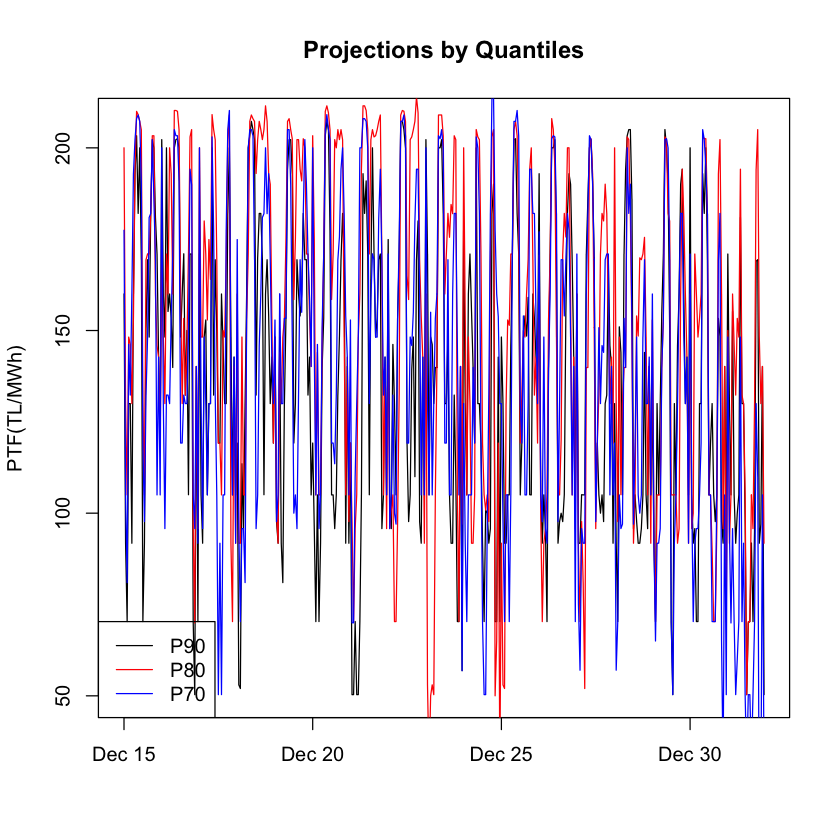

In [32]:
load('forecastedQuantiles.rda')
xAxis=seq(from=as.POSIXct('2017-12-15 00:00'),length.out = nrow(yearEnd), by='hour')
plot(xAxis,yearEnd$P90, type='l', xlab='', ylab='PTF(TL/MWh)',main='Projections by Quantiles')
lines(xAxis,yearEnd$P80, col='red')
lines(xAxis,yearEnd$P70, col='blue')
legend('bottomleft',legend = c('P90', 'P80', 'P70'), col = c('black','red','blue'), lty = c(1,1,1),cex = 1)